# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-12 09:00:00+09:00,50988.531250,51017.839844,50537.500000,50621.718750,0,0.0,0.0
2025-11-12 09:15:00+09:00,50613.960938,50866.730469,50579.078125,50750.128906,0,0.0,0.0
2025-11-12 09:30:00+09:00,50752.230469,50962.121094,50752.230469,50955.890625,0,0.0,0.0
2025-11-12 09:45:00+09:00,50957.121094,50965.511719,50860.421875,50880.011719,0,0.0,0.0
2025-11-12 10:00:00+09:00,50885.800781,51008.148438,50867.289062,50913.839844,0,0.0,0.0
2025-11-12 10:15:00+09:00,50916.031250,50944.289062,50814.539062,50829.410156,0,0.0,0.0
2025-11-12 10:30:00+09:00,50838.621094,50917.039062,50809.250000,50917.039062,0,0.0,0.0
2025-11-12 10:45:00+09:00,50914.960938,51018.691406,50879.871094,50956.320312,0,0.0,0.0
2025-11-12 11:00:00+09:00,50956.589844,51006.480469,50924.539062,50995.031250,0,0.0,0.0


## 前日終値の取得

In [4]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-11-05 00:00:00+09:00    50212.269531
2025-11-06 00:00:00+09:00    50883.679688
2025-11-07 00:00:00+09:00    50276.371094
2025-11-10 00:00:00+09:00    50911.761719
2025-11-11 00:00:00+09:00    50842.929688
2025-11-12 00:00:00+09:00    50740.128906
Name: Close, dtype: float64


Date
2025-11-11 00:00:00+09:00    50842.929688
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [5]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+145.60


## ローソク足チャート（小さいサイズ）

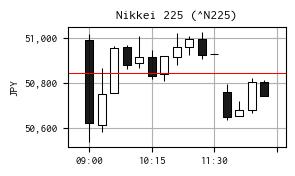

In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [7]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [8]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-11 09:00:00+09:00,154.145996,154.201004,154.097000,154.164993,0,0.0,0.0
2025-11-11 09:15:00+09:00,154.169998,154.195007,154.106003,154.192993,0,0.0,0.0
2025-11-11 09:30:00+09:00,154.188004,154.285995,154.158997,154.253998,0,0.0,0.0
2025-11-11 09:45:00+09:00,154.253998,154.311005,154.212997,154.309998,0,0.0,0.0
2025-11-11 10:00:00+09:00,154.309006,154.432007,154.302994,154.384003,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-12 12:30:00+09:00,154.272003,154.322006,154.266998,154.307999,0,0.0,0.0
2025-11-12 12:45:00+09:00,154.304001,154.348999,154.296997,154.341995,0,0.0,0.0
2025-11-12 13:00:00+09:00,154.339996,154.447006,154.335007,154.423996,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [9]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-12 09:00:00+09:00,330.967547,331.157790,328.039895,328.586560
2025-11-12 09:15:00+09:00,328.291166,329.930674,328.064910,329.174376
2025-11-12 09:30:00+09:00,329.040746,330.401525,329.040746,330.361131
2025-11-12 09:45:00+09:00,330.262043,330.316424,329.635318,329.762283
2025-11-12 10:00:00+09:00,329.748507,330.541340,329.628548,329.930205
2025-11-12 10:15:00+09:00,329.967930,330.151058,329.310196,329.406570
2025-11-12 10:30:00+09:00,329.461995,329.970186,329.271654,329.970186
2025-11-12 10:45:00+09:00,329.924649,330.596814,329.697270,330.192654
2025-11-12 11:00:00+09:00,330.132348,330.455574,329.924701,330.381398


### 前日の終値のドル円レートから、前日の終値のドル換算

In [10]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-11 15:15:00+09:00


np.float64(154.22000122070312)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 329.6779230000073


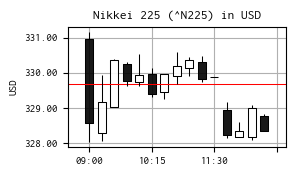

In [11]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()